In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import os
import random
import datetime
from itertools import product
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling, MaxPool2D
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED)

In [29]:
# the data_path is obtained after operations in the data_exploration.ipynb
data_path = 'data/redistributed'
train_path = Path(data_path) / 'train'
test_path = Path(data_path) / 'test'
val_path = Path(data_path) / 'val'

LABELS = ['NORMAL', 'PNEUMONIA']
IMG_SIZE = 224
GRAYSCALE = True
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 0.001
color_mode = 'grayscale' if GRAYSCALE else 'rgb'

# Loading Dataset

In [6]:
train = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='int',
    class_names=LABELS,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED
)

val = image_dataset_from_directory(
    val_path,
    labels='inferred',
    label_mode='int',
    class_names=LABELS,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

test = image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='int',
    class_names=LABELS,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

Found 6293 files belonging to 2 classes.
Found 586 files belonging to 2 classes.
Found 586 files belonging to 2 classes.


## Hypermarater Tuning

In [88]:
hyperparameter_space = {
    'optimizer': [Adam, AdamW],
    'loss_function': [BinaryCrossentropy(), BinaryFocalCrossentropy()],
    'learning_rate': [0.01, 0.001, 0.0001],
    'epochs': [10, 15, 20],
    'batch_size': [16, 32],
}

def generate_random_combinations(hyperparameter_space, num_samples=5, seed=42):
    random_generator = random.Random(seed) 
    keys = list(hyperparameter_space.keys())
    values = list(hyperparameter_space.values())
    all_combinations = list(product(*values))
    return random_generator.sample(all_combinations, min(len(all_combinations), num_samples))



In [93]:
random_combinations = generate_random_combinations(hyperparameter_space, num_samples=10, seed=1)
for i, combo in enumerate(random_combinations):
    optimizer_cls, loss_function, learning_rate, epochs, batch_size = combo
    print(f"Combination {i+1}:")
    print({
        'optimizer': optimizer_cls.__name__,
        'loss_function': loss_function.__class__.__name__,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'batch_size': batch_size
    })

Combination 1:
{'optimizer': 'Adam', 'loss_function': 'BinaryCrossentropy', 'learning_rate': 0.0001, 'epochs': 20, 'batch_size': 32}
Combination 2:
{'optimizer': 'Adam', 'loss_function': 'BinaryCrossentropy', 'learning_rate': 0.001, 'epochs': 15, 'batch_size': 16}
Combination 3:
{'optimizer': 'Adam', 'loss_function': 'BinaryFocalCrossentropy', 'learning_rate': 0.0001, 'epochs': 15, 'batch_size': 16}
Combination 4:
{'optimizer': 'Adam', 'loss_function': 'BinaryCrossentropy', 'learning_rate': 0.0001, 'epochs': 15, 'batch_size': 32}
Combination 5:
{'optimizer': 'AdamW', 'loss_function': 'BinaryFocalCrossentropy', 'learning_rate': 0.001, 'epochs': 15, 'batch_size': 32}
Combination 6:
{'optimizer': 'AdamW', 'loss_function': 'BinaryFocalCrossentropy', 'learning_rate': 0.01, 'epochs': 15, 'batch_size': 32}
Combination 7:
{'optimizer': 'AdamW', 'loss_function': 'BinaryFocalCrossentropy', 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 16}
Combination 8:
{'optimizer': 'AdamW', 'loss_functio

# Data Preprocessing

## Data Normalization

In [7]:
normalization_layer = Rescaling(1./255)

train = train.map(lambda x, y: (normalization_layer(x), y))
val = val.map(lambda x, y: (normalization_layer(x), y))
test = test.map(lambda x, y: (normalization_layer(x), y))

In [7]:
train.as_numpy_iterator().next()[0].max()

1.0

In [8]:
train.as_numpy_iterator().next()[0].min()

0.0

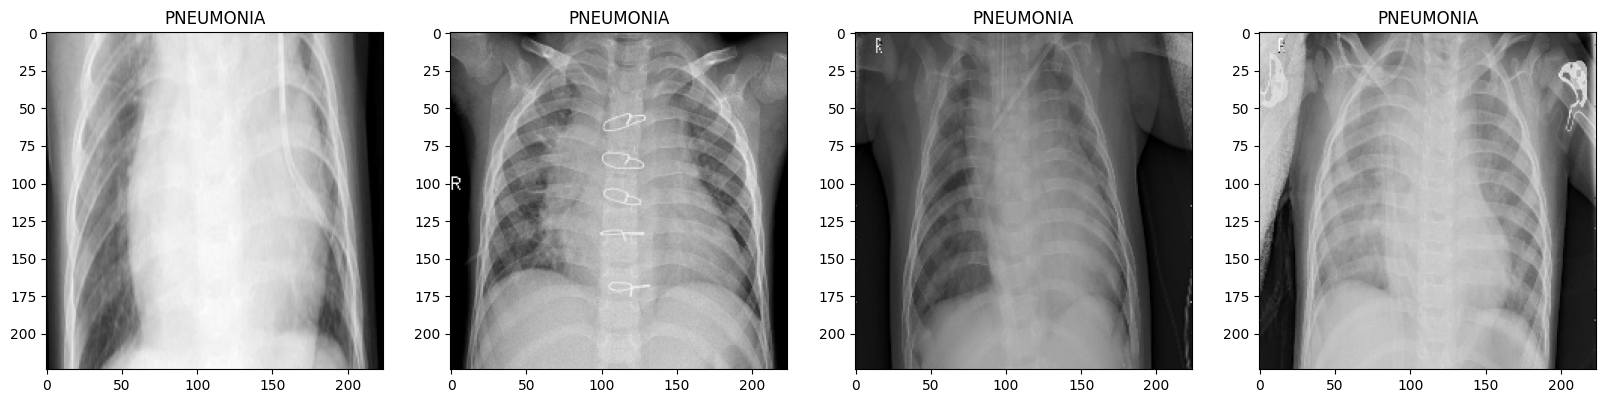

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
batch = train.as_numpy_iterator().next()
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img, cmap='gray')
    ax[idx].title.set_text(LABELS[batch[1][idx]])

## Data Optimization

In [8]:
# use tensorflow to prefetch data for better performance
train_ds = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
for images, labels in train_ds.take(1):
    print(f"Image shape: {images.shape}, dtype: {images.dtype}")
    print(f"Label shape: {labels.shape}, dtype: {labels.dtype}")

for images, labels in val.take(1):
    print(f"Image shape: {images.shape}, dtype: {images.dtype}")
    print(f"Label shape: {labels.shape}, dtype: {labels.dtype}")

for images, labels in test.take(1):
    print(f"Image shape: {images.shape}, dtype: {images.dtype}")
    print(f"Label shape: {labels.shape}, dtype: {labels.dtype}")

Image shape: (16, 224, 224, 1), dtype: <dtype: 'float32'>
Label shape: (16,), dtype: <dtype: 'int32'>
Image shape: (16, 224, 224, 1), dtype: <dtype: 'float32'>
Label shape: (16,), dtype: <dtype: 'int32'>
Image shape: (16, 224, 224, 1), dtype: <dtype: 'float32'>
Label shape: (16,), dtype: <dtype: 'int32'>


# Model Building

In [30]:
def build_base_model(optimizer, metrics, loss_function, input_shape=(150, 150, 1)):
    model = Sequential()

    # convolutional layer 1
    model.add(Conv2D(32 , (3,3) , strides=1 , padding='same' , activation = 'relu', input_shape=input_shape, name="conv1_1"))
    model.add(BatchNormalization(name="batchnorm_1"))
    model.add(MaxPool2D((2,2) , strides=2 , padding = 'same', name="maxpool2d_1"))

    # convolutional layer 2
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', name="conv2_1"))
    model.add(Dropout(0.1, name="dropout_1"))
    model.add(BatchNormalization(name="batchnorm_2"))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same', name="maxpool2d_2"))

    # convolutional layer 3
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', name="conv3_1"))
    model.add(BatchNormalization(name="batchnorm_3"))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same', name="maxpool2d_3"))

    # convolutional layer 4
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', name="conv4_1"))
    model.add(Dropout(0.2, name="dropout_2"))
    model.add(BatchNormalization(name="batchnorm_4"))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same', name="maxpool2d_4"))

    # convolutional layer 5
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', name="conv5_1"))
    model.add(Dropout(0.2, name="dropout_3"))
    model.add(BatchNormalization(name="batchnorm_5"))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same', name="maxpool2d_5"))

    # flattening the layers
    model.add(Flatten(name='flatten'))

    # fully connected layer 1
    model.add(Dense(units=128 , activation = 'relu', name='fc1'))
    model.add(Dropout(0.3, name="dropout_4"))

    # output layer
    model.add(Dense(units=1 , activation = 'sigmoid', name='output'))

    model.compile(optimizer=optimizer, 
                  loss=loss_function,
                  metrics=metrics)
    return model


loss_function, optimizer = BinaryCrossentropy(), Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
model = build_base_model(optimizer=optimizer,
                        metrics=METRICS,
                        loss_function=loss_function,
                        input_shape=(IMG_SIZE, IMG_SIZE, 1))
model.summary()

/home/an/miniconda3/envs/aa1/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_4 (MaxPooling2D)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_1 (Conv2D)                │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_5 (MaxPooling2D)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 2,032,833 (7.75 MB)

 Trainable params: 2,031,745 (7.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

# Model training

In [31]:
train_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_type = 'cnn'

# callback to reduce learning rate when the model stops improving
lr_reduction_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-6)

# save best model
checkpoint_filepath = os.path.join('models', model_type, train_time, "checkpoint.model.keras")
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

# tensorboard callback
log_dir = os.path.join("logs", model_type, train_time)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

In [32]:
history = model.fit(train_ds, 
                    epochs=EPOCHS, 
                    validation_data=val_ds, 
                    callbacks=[lr_reduction_callback, model_checkpoint_callback, tensorboard_callback, early_stopping_callback])

Epoch 1/15


2025-01-08 20:42:58.863804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


393/394 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8546 - loss: 0.6704
Epoch 1: val_accuracy improved from -inf to 0.69795, saving model to models/cnn/20250108-204255/checkpoint.model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.8548 - loss: 0.6688 - val_accuracy: 0.6980 - val_loss: 7.6505 - learning_rate: 0.0010
Epoch 2/15
393/394 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9428 - loss: 0.1716
Epoch 2: val_accuracy improved from 0.69795 to 0.92491, saving model to models/cnn/20250108-204255/checkpoint.model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step - accuracy: 0.9429 - loss: 0.1715 - val_accuracy: 0.9249 - val_loss: 0.1890 - learning_rate: 0.0010
Epoch 3/15
393/394 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9522 - loss: 0.1439
Epoch 3: val_accuracy did not improve from 0.92491
394/394 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step - accuracy: 0.9522 - loss: 0.1438 - val_accuracy: 0.8618 - val_loss: 0.3401 - learning_rate: 0.0010
Epoch 4/15
393/394 ━━━━━━━━━━

In [33]:
# load best model
model = load_model(checkpoint_filepath)

# Model evaluation

In [34]:
res_dir = os.path.join("res", model_type, train_time)
os.makedirs(res_dir, exist_ok=True)

In [35]:
print("Test Set Evaluation")
loss, accuracy = model.evaluate(test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy * 100}%")

Test Set Evaluation
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9608 - loss: 0.1197
Loss: 0.11942587047815323
Accuracy: 96.58703207969666%


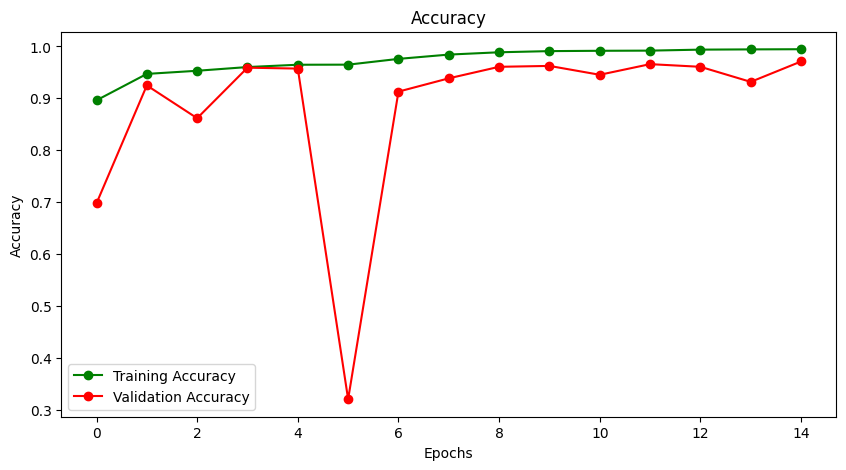

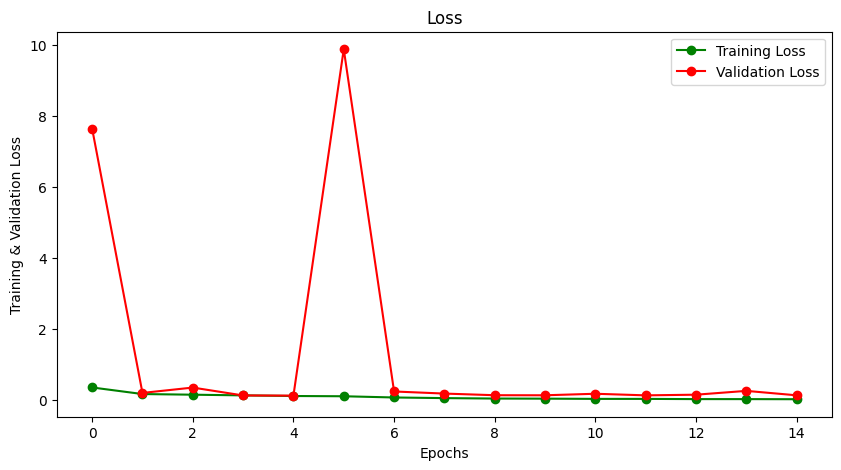

In [36]:
x_epochs = [i for i in range(EPOCHS)]

# train metrics
train_acc = history.history['accuracy']
train_loss = history.history['loss']

# validation metrics
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot and save Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(x_epochs, train_acc, 'go-', label='Training Accuracy')
plt.plot(x_epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig(os.path.join(res_dir, "training_accuracy.png"))
plt.show()

# Plot and save Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(x_epochs, train_loss, 'g-o', label='Training Loss')
plt.plot(x_epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training & Validation Loss")
plt.savefig(os.path.join(res_dir, "training_loss.png"))
plt.show()

In [37]:
predictions = (model.predict(test) > 0.5).astype(int) # for binary classification
y_pred = predictions.reshape(predictions.shape[0])
y_pred

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [38]:
y_true = []
for _, labels in test.unbatch():
    y_true.append(labels.numpy())
y_true = np.array(y_true)

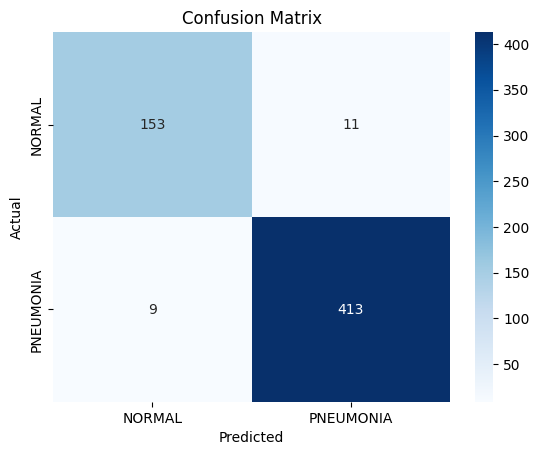

In [39]:
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABELS,
            yticklabels=LABELS)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, columns=LABELS, index=LABELS)
conf_matrix_df.to_csv(os.path.join(res_dir, "confusion_matrix.csv"))

In [40]:
report = classification_report(y_true, y_pred, target_names=LABELS)
print(report)

# save classification report
with open(os.path.join(res_dir, "classification_report.txt"), "w") as f:
    f.write(report)

              precision    recall  f1-score   support

      NORMAL       0.94      0.93      0.94       164
   PNEUMONIA       0.97      0.98      0.98       422

    accuracy                           0.97       586
   macro avg       0.96      0.96      0.96       586
weighted avg       0.97      0.97      0.97       586



: 